<a href="https://colab.research.google.com/github/simodepth/Similarity-Tool/blob/main/Top_SERP_similarity_tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SERP Similarity Tool with Serp API and Polyfuzz



---

##Description
The aim of this framework is to allow users to compare search results depending on their search query. The following script is designed to help users inform decision-making following a competitor analysis drilled on the search queries similarity.

In particular, users will be able to:
- ✅ Compare 2 SERPs concurrently 
- ✅ Benchmarking URLs, snippets, highlighted words in a snippet and more
- ✅ Analyzing n-grams (string only) 


##Requirements and Assumptions

- Serp Api to retrieve search results page. You can sign up for free and opening an account in seconds, then you will have granted a free starting credits to play around with the API.
- It is recommended users are quite confident with the basics of Pandas as thhis framework focuses largely on manipulating information within this powerful Python library
- NLTK library will be used for tokenization purposes before whilst the Snowball stemmer will be leveraged for stemming objectives. This will take place for everything strings-related before calculating the similarity score
- **IMPORTANT** The script looks like a long deck but it's actually doubled to give users the opportunity to flex the code for each SERP. It is, in fact, recommended to take a moment to read the instructions before running every scripts to avoid any unpleasant bugs.

##Credits
This framework saw the light thanks to the following sources of inspiration:
- [Redirect Matching Automation](https://seoalex.es/scripts-python-seo/script-para-generar-redirecciones-automaticamente/) by Alex Romero Lopez
- [Query Analysis](https://colab.research.google.com/drive/1-rjEyItRQB0K0ptKTa4YyVAKtf8AutJu#scrollTo=72lvaLdOOfg_) (adapted Google Colab file) by Marco Giordano

In [ ]:
#@title Install Required Libraries
!pip install polyfuzz
!pip install google-search-results
!pip install plotly
!pip install gensim

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px

#Libraries for preprocessing
from gensim.parsing.preprocessing import remove_stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize

#Download once if using NLTK for preprocessing
import nltk
nltk.download('punkt')

#Libraries for vectorisation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Libraries for clustering
from sklearn.cluster import KMeans
from polyfuzz.models import TFIDF
from polyfuzz import PolyFuzz


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.2 MB 22.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for google-search-results: filename=google_search_results-2.4.1-py3-none-any.whl size=25789 sha256=0f0bbf95d497e8ebd6f8515a1f56bbc48a1b6326e4ea56edc5ac87d9fa634e40
  Stored in directory: /root/.cache/pip/wheels/82/a3/c5/364155118f298722dff2f79ae4dd7c91e92b433ad36d6f7e0e
Successfully built google-search-results
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#Kick off the **First** SERP Audit with Google Search Api


---

What you need to do here is just a couple of tiny things.
- log in to [Serp Api](https://serpapi.com/), heading on to your account and copy and paste the API code in the `serp_apikey`
- include your search query in the payload after the `"q"`

In [ ]:
from serpapi import GoogleSearch

serp_apikey = "######" 

params = {
    "engine": "google",
    "q": "latte",
    "location": "United Kingdom",
    "google_domain": "google.com",
    "gl": "uk",
    "hl": "en",
    "num": 10,
    "api_key": serp_apikey
}

client = GoogleSearch(params)
data = client.get_dict()

# access "organic results"
df = pd.DataFrame(data['organic_results'])
df.to_csv('results_1.csv', index=False)
df

https://serpapi.com/search


,position,title,link,displayed_link,thumbnail,snippet,snippet_highlighted_words,sitelinks,about_this_result,about_page_link,about_page_serpapi_link,cached_page_link,related_pages_link,related_questions,date
0,1,Latte - Wikipedia,https://en.wikipedia.org/wiki/Latte,https://en.wikipedia.org › wiki › Latte,https://serpapi.com/searches/634addb09790545a4...,Caffè latte often shortened to just latte in E...,"[latte, latte]","{'inline': [{'title': 'Origin and history', 'l...",{'source': {'description': 'Wikipedia is a mul...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,https://www.google.com/search?gl=uk&hl=en&q=re...,NaN,NaN
1,2,Latte recipe | BBC Good Food,https://www.bbcgoodfood.com/recipes/latte,https://www.bbcgoodfood.com › Recipes,https://serpapi.com/searches/634addb09790545a4...,Make around 35ml espresso using your coffee ma...,NaN,NaN,{'source': {'description': 'BBC Good Food is a...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,NaN,NaN
2,3,What is a Latte? Origins & Differences | Nesca...,https://www.nescafe.com/gb/coffee-types/what-i...,https://www.nescafe.com › Home › Types of Coffee,NaN,A latte or caffè latte is a milk coffee that i...,"[latte, latte]",NaN,{'source': {'description': 'Nescafé is a brand...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,"[{'question': 'Does latte mean milk?', 'snippe...",NaN
3,4,How to Make a Latte: Easy Homemade Caffe Latte...,https://www.goodhousekeeping.com/food-recipes/...,https://www.goodhousekeeping.com › ... › Cooki...,https://encrypted-tbn0.gstatic.com/images?q=tb...,A latte — also known as a caffe latte or latte...,"[latte, latte, latte, latte]",NaN,{'source': {'description': 'Good Housekeeping ...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,NaN,11 Jul 2022
4,5,Caffè Latte: Starbucks Coffee Company,https://www.starbucks.com/menu/product/407/hot,https://www.starbucks.com › menu › product › hot,https://encrypted-tbn0.gstatic.com/images?q=tb...,"Our dark, rich espresso balanced with steamed ...",NaN,NaN,{'source': {'description': 'Starbucks Corporat...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,NaN,NaN
5,6,"Caffe latte, latte, macchiato, cappuccino... w...",https://www.liminicoffee.co.uk/article_latte_c...,https://www.liminicoffee.co.uk › article_latte...,https://encrypted-tbn0.gstatic.com/images?q=tb...,Latte simply means milk in Italian. So latte i...,"[Latte, latte, latte]",NaN,{'source': {'description': 'liminicoffee.co.uk...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,NaN,NaN
6,7,latte - Wiktionary,https://en.wiktionary.org/wiki/latte,https://en.wiktionary.org › wiki › latte,NaN,A drink of coffee made from espresso and steam...,NaN,NaN,{'source': {'description': 'Wiktionary is a mu...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,https://www.google.com/search?gl=uk&hl=en&q=re...,NaN,NaN
7,8,Cappuccino vs. Latte: What's the Difference? -...,https://www.coffeebean.com/blog/our-coffee/cap...,https://www.coffeebean.com › blog › our-coffee...,NaN,A latte begins with the same base — a single o...,[latte],NaN,{'source': {'description': 'The Coffee Bean & ...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,NaN,11 Nov 2019


In [ ]:
#@title Creating a Dataframe to View/Manipulate Data
SERP_One = pd.read_csv('/content/results_1.csv')
df = pd.DataFrame(SERP_One, columns=['link'])
df.columns = ['URL1']
df

,URL1
0,https://en.wikipedia.org/wiki/Latte
1,https://www.bbcgoodfood.com/recipes/latte
2,https://www.nescafe.com/gb/coffee-types/what-i...
3,https://www.goodhousekeeping.com/food-recipes/...
4,https://www.starbucks.com/menu/product/407/hot
5,https://www.liminicoffee.co.uk/article_latte_c...
6,https://en.wiktionary.org/wiki/latte
7,https://www.coffeebean.com/blog/our-coffee/cap...


In [ ]:
#@title Snippet Highlighted Words: Data Cleaning (Optional)

df ['Highlighted_Words1'] =  df ['Highlighted_Words1'].str.replace("\[|\"|\]|\'", "")
df = df.fillna(0)
df.isnull().sum()
df

In [ ]:
#@title Snippet Benchmarking: N-Grams Analysis (Optional)
import nltk
textlist = df['Snippet1'].to_list()

from collections import Counter
x = Counter(textlist)

#download stopwords list to remove what is not needed
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

#create dataframe with bigrams and trigrams
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3)) #can also select bigrams only
# matrix of ngrams
ngrams = c_vec.fit_transform(df['Snippet1'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
            
#Get the output
df_ngram.head(20).style.background_gradient()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,frequency,bigram/trigram
0,5,steamed milk
1,3,espresso steamed milk
2,3,espresso steamed
3,2,made espresso steamed
4,2,made espresso
5,2,coffee made
6,2,caffè latte
7,1,warm 190 calories
8,1,warm 190
9,1,volume 407 number


#Kick off the **Second** SERP Audit with Google Search Api



---

Rinse and repeat the same process as for the First SERP Audit 

In [ ]:
#@title SERP Audit with Google Search Api

from serpapi import GoogleSearch

serp_apikey = "########" 

params = {
    "engine": "google",
    "q": "cappuccino",
    "location": "United Kingdom",
    "google_domain": "google.com",
    "gl": "uk",
    "hl": "en",
    "num": 10,
    "api_key": serp_apikey
}

client = GoogleSearch(params)
data = client.get_dict()

# access "organic results"
df2 = pd.DataFrame(data['organic_results'])
df2.to_csv('results_2.csv', index=False)
df2

https://serpapi.com/search


,position,title,link,displayed_link,thumbnail,snippet,snippet_highlighted_words,sitelinks,about_this_result,about_page_link,about_page_serpapi_link,cached_page_link,related_pages_link,date,rich_snippet
0,1,Cappuccino - Wikipedia,https://en.wikipedia.org/wiki/Cappuccino,https://en.wikipedia.org › wiki › Cappuccino,https://serpapi.com/searches/634adde033b236212...,A cappuccino is an espresso-based coffee drink...,"[cappuccino, Cappuccino]","{'inline': [{'title': 'Microfoam', 'link': 'ht...",{'source': {'description': 'Wikipedia is a mul...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,https://www.google.com/search?ucbcb=1&hl=en&gl...,NaN,NaN
1,2,Perfect Cappuccino Recipe - The Spruce Eats,https://www.thespruceeats.com/how-to-make-capp...,https://www.thespruceeats.com › how-to-make-ca...,https://serpapi.com/searches/634adde033b236212...,A cappuccino is an Italian coffee drink that i...,[cappuccino],NaN,{'source': {'description': 'thespruceeats.com ...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,28 Jun 2022,{'bottom': {'detected_extensions': {'prep_mins...
2,3,Cappuccino recipe | BBC Good Food,https://www.bbcgoodfood.com/recipes/cappuccino,https://www.bbcgoodfood.com › Recipes,https://serpapi.com/searches/634adde033b236212...,Make your favourite morning coffee from scratc...,[cappuccino],NaN,{'source': {'description': 'BBC Good Food is a...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,NaN,NaN
3,4,How to Make a Cappuccino at Home - Coffee Prep...,https://www.illy.com/en-gb/coffee/coffee-prepa...,https://www.illy.com › en-gb › how-to-make-cap...,NaN,For a cappuccino at its best: Pour cold milk i...,[cappuccino],NaN,{'source': {'description': 'Illycaffè S.p.A. i...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,NaN,NaN
4,5,How to Make a Cappuccino | Barista Tips - Caff...,https://www.caffesociety.co.uk/how-to-make-a-c...,https://www.caffesociety.co.uk › how-to-make-a...,https://encrypted-tbn0.gstatic.com/images?q=tb...,Quick guide · Foam and texture the required qu...,NaN,NaN,{'source': {'description': 'caffesociety.co.uk...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,https://www.google.com/search?ucbcb=1&hl=en&gl...,NaN,NaN
5,6,How to Make Cappuccino - A Couple Cooks,https://www.acouplecooks.com/how-to-make-cappu...,https://www.acouplecooks.com › how-to-make-cap...,https://encrypted-tbn0.gstatic.com/images?q=tb...,A cappuccino is an espresso drink with steamed...,[cappuccino],NaN,{'source': {'description': 'acouplecooks.com w...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,21 Sept 2020,NaN
6,7,Lume Collection - Porcelain Cappuccino Cups - ...,https://www.nespresso.com/uk/en/order/accessor...,https://www.nespresso.com › accessories › orig...,NaN,The Lume Collection porcelain cappuccino cups ...,[cappuccino],NaN,{'source': {'description': 'Nestlé Nespresso S...,https://www.google.com/search?q=About+https://...,https://serpapi.com/search.json?engine=google_...,https://webcache.googleusercontent.com/search?...,NaN,NaN,{'top': {'detected_extensions': {'price': 23.0...
7,8,Cappuccino vs. Latte: What's the Difference? -...,https://www.coffeebean.com/blog/our-coffee/cap...,https://www.coffeebean.com › blog › our-coffee...,NaN,Perfected and made popular during both World W...,[cappuccino],NaN,{'source': {'description': 'The Coffee Bean & ...,https://www.google.com/search?q=About+https://...,https://serpapi.co

In [ ]:
#@title Creating a Dataframe to View/Manipulate Data (2)
SERP_Two = pd.read_csv('/content/results_2.csv')
df2 = pd.DataFrame(SERP_Two, columns=['link'])
df2.columns = ['URL2']
df2

,URL2
0,https://en.wikipedia.org/wiki/Cappuccino
1,https://www.thespruceeats.com/how-to-make-capp...
2,https://www.bbcgoodfood.com/recipes/cappuccino
3,https://www.illy.com/en-gb/coffee/coffee-prepa...
4,https://www.caffesociety.co.uk/how-to-make-a-c...
5,https://www.acouplecooks.com/how-to-make-cappu...
6,https://www.nespresso.com/uk/en/order/accessor...
7,https://www.coffeebean.com/blog/our-coffee/cap...


In [ ]:
#@title Snippet Highlighted Words: Data Cleaning (Optional 2)

df2 ['Highlighted_Words2'] =  df2 ['Highlighted_Words2'].str.replace("\[|\"|\]|\'", "")
df2

In [ ]:
#@title Snippet Benchmarking: N-Grams Analysis (Optional 2)
import nltk
textlist = df2['Snippet2'].to_list()

from collections import Counter
x = Counter(textlist)

#download stopwords list to remove what is not needed
nltk.download('stopwords')
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

#create dataframe with bigrams and trigrams
from sklearn.feature_extraction.text import CountVectorizer
c_vec = CountVectorizer(stop_words=stoplist, ngram_range=(2,3)) #can also select bigrams only
# matrix of ngrams
ngrams = c_vec.fit_transform(df2['Snippet2'])
# count frequency of ngrams
count_values = ngrams.toarray().sum(axis=0)
# list of ngrams
vocab = c_vec.vocabulary_
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
            
#Get the output
df_ngram.head(20).style.background_gradient()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,frequency,bigram/trigram
0,4,steamed milk
1,3,milk foam
2,2,steamed milk foam
3,2,double espresso
4,2,coffee drink
5,2,cappuccino espresso
6,1,world wars cappuccino
7,1,world wars
8,1,wars cappuccino starts
9,1,wars cappuccino


#Comparing the Object of your Analysis


---

we use `pd.concat` from Pandas to merge together columsn that were inspected so that we can start the stup to create the similarity score environment

In [ ]:
Comparison = pd.concat([df, df2], axis=1)
Comparison = Comparison.dropna()
Comparison

,URL1,URL2
0,https://en.wikipedia.org/wiki/Latte,https://en.wikipedia.org/wiki/Cappuccino
1,https://www.bbcgoodfood.com/recipes/latte,https://www.thespruceeats.com/how-to-make-capp...
2,https://www.nescafe.com/gb/coffee-types/what-i...,https://www.bbcgoodfood.com/recipes/cappuccino
3,https://www.goodhousekeeping.com/food-recipes/...,https://www.illy.com/en-gb/coffee/coffee-prepa...
4,https://www.starbucks.com/menu/product/407/hot,https://www.caffesociety.co.uk/how-to-make-a-c...
5,https://www.liminicoffee.co.uk/article_latte_c...,https://www.acouplecooks.com/how-to-make-cappu...
6,https://en.wiktionary.org/wiki/latte,https://www.nespresso.com/uk/en/order/accessor...
7,https://www.coffeebean.com/blog/our-coffee/cap...,https://www.coffeebean.com/blog/our-coffee/cap...


In [ ]:
#@title Ensure your Data Columns are on the same page as of Length
URL1 = Comparison['URL1'].tolist()
cleanedList = [x for x in URL1 if str(x) != 'nan']
len(URL1)

8

In [ ]:
URL2 = Comparison['URL2'].tolist()
cleanedList2 = [x for x in URL2 if str(x) != 'nan']
len(URL2)

8

In [ ]:
#@title Calculate TF-IDF of submitted values 
tfidf = TFIDF(n_gram_range=(3,3), min_similarity=0.95, cosine_method='knn')
model = PolyFuzz(tfidf)
model.match(cleanedList, cleanedList2)
similarity = model.get_matches()

In [ ]:
#@title Display the Output
outcome = pd.DataFrame(similarity)
outcome.sort_values('Similarity', ascending=False, inplace=True)
outcome

,From,To,Similarity
7,https://www.coffeebean.com/blog/our-coffee/cap...,https://www.coffeebean.com/blog/our-coffee/cap...,1.000
1,https://www.bbcgoodfood.com/recipes/latte,https://www.bbcgoodfood.com/recipes/cappuccino,0.852
0,https://en.wikipedia.org/wiki/Latte,https://en.wikipedia.org/wiki/Cappuccino,0.828
6,https://en.wiktionary.org/wiki/latte,https://en.wikipedia.org/wiki/Cappuccino,0.453
5,https://www.liminicoffee.co.uk/article_latte_c...,https://www.coffeebean.com/blog/our-coffee/cap...,0.268
3,https://www.goodhousekeeping.com/food-recipes/...,https://www.bbcgoodfood.com/recipes/cappuccino,0.254
2,https://www.nescafe.com/gb/coffee-types/what-i...,https://www.illy.com/en-gb/coffee/coffee-prepa...,0.221
4,https://www.starbucks.com/menu/product/407/hot,https://www.acouplecooks.com/how-to-make-cappu...,0.093


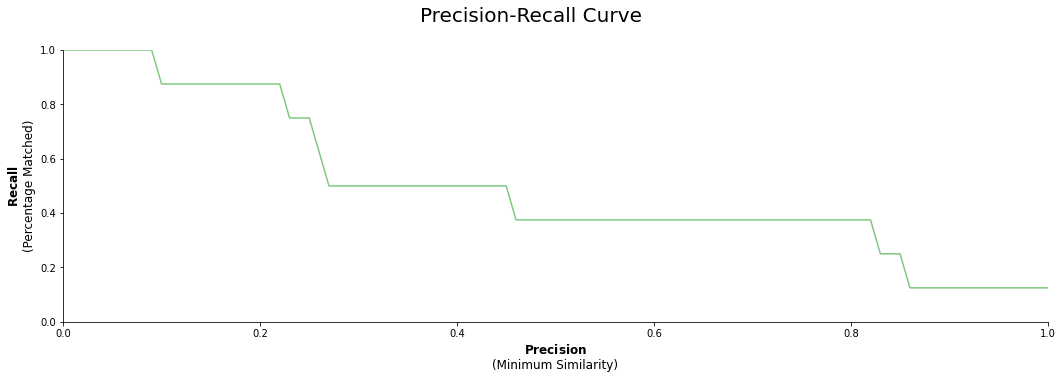

In [ ]:
#@title Precision-Recall Curve to visualize the Similarity Scores
model.visualize_precision_recall()

In [ ]:
#@title Save the Dataframe
outcome.to_csv('similarity_score.csv', index=False)